# CNN Multi-Categorical Classification
In this notebook I create a CNN that makes a prediction for the direction and magnitude of a stock's movement 10 days into the future with the only input being the stock chart image created in the previous notebook.  To start I import libraries and create the architecture necessary to split the data into train, validate and test sets and then feed the images into the model.  Keep in mind that the return and error values are scaled to the range of the last 100 days of a stock's trading.  For example, if a stock is currently trading at \\$100 and its high and low for the past 100 days is \\$101 and \\$99 respectively; then a \\$1 move will result in a value of 100.

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os, shutil
import glob
import cv2
from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import optimizers
import pickle
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from scipy import stats

pickle_in=open("x_train.pickle","rb")
x_train=pickle.load(pickle_in)
pickle_in=open("x_valid.pickle","rb")
x_valid=pickle.load(pickle_in)
pickle_in=open("x_test.pickle","rb")
x_test=pickle.load(pickle_in)
pickle_in=open("y_train.pickle","rb")
y_train=pickle.load(pickle_in)
pickle_in=open("y_valid.pickle","rb")
y_valid=pickle.load(pickle_in)
pickle_in=open("y_test.pickle","rb")
y_test=pickle.load(pickle_in)
pickle_in=open("invest_return_test.pickle","rb")
invest_return_test=pickle.load(pickle_in)
pickle_in=open("invest_return_valid.pickle","rb")
invest_return_valid=pickle.load(pickle_in)
pickle_in=open("invest_return_train.pickle","rb")
invest_return_train=pickle.load(pickle_in)
pickle_in=open("trade_dates.pickle","rb")
trade_dates=pickle.load(pickle_in)
pickle_in=open("ticker.pickle","rb")
ticker=pickle.load(pickle_in)
pickle_in=open("true_return_test.pickle","rb")
true_return_test=pickle.load(pickle_in)
pickle_in=open("true_return_valid.pickle","rb")
true_return_valid=pickle.load(pickle_in)
pickle_in=open("true_return_train.pickle","rb")
true_return_train=pickle.load(pickle_in)
pickle_in=open("results.pickle","rb")
results=pickle.load(pickle_in)

# This section creates the categorical variables that will be used to seperate the images into 
# their propper folders
clean_results=results.copy()
clean_results.reset_index(drop=True,inplace=True)
buckets=[]
for i in range(len(clean_results)):
    buckets.append(int(clean_results.finish[i]*100*.5)/.5)
buckets=pd.DataFrame(buckets,columns=['buckets'])
clean_results=clean_results.merge(buckets,left_index=True,right_index=True)

Using TensorFlow backend.


In [2]:
old_dir = 'all_charts/'   # Define where all of the charts come from
new_root_dir = 'data_org/'# Define where all of the seperated charts are going
os.mkdir(new_root_dir)
dir_names = ['train', 'val', 'test']
class_names=[]
for d in dir_names:
    new_dir = os.path.join(new_root_dir, d)
    os.mkdir(new_dir)
for k in clean_results.buckets.unique():
    print('Moving {} pictures.'.format(k))
    #Create sub_directories
    for d in dir_names:
        new_dir = os.path.join(new_root_dir, d, str(k))
        os.mkdir(new_dir)
    #Subset dataframe into train, validate and split sets
    #Split is performed here to ensure maintain class distributions.
    temp = clean_results[clean_results.buckets == k]
    train, validate, test = np.split(temp.sample(frac=1), [int(.8*len(temp)), int(.9*len(temp))])
    print('Split {} imgs into {} train, {} val, and {} test examples.'.format(len(temp),
                                                                              len(train),
                                                                              len(validate),
                                                                              len(test)))
    for j, temp in enumerate([train, validate, test]):
        for row in temp.index:
            filename = 'plot'+str(temp.i[row]) + '.png'
            origin = os.path.join(old_dir + filename)
            destination = os.path.join(new_root_dir + dir_names[j] + '/' + str(k) + '/' + filename)
            shutil.copy(origin, destination)

train_dir = 'data_org/train'
validation_dir = 'data_org/val/'
test_dir = 'data_org/test/'

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(107, 107),
        batch_size=20,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(107, 107),
        batch_size=20,
        class_mode='categorical',
        shuffle=False)

Moving 2.0 pictures.
Split 513 imgs into 410 train, 51 val, and 52 test examples.
Moving 4.0 pictures.
Split 562 imgs into 449 train, 56 val, and 57 test examples.
Moving 18.0 pictures.
Split 322 imgs into 257 train, 32 val, and 33 test examples.
Moving 12.0 pictures.
Split 442 imgs into 353 train, 44 val, and 45 test examples.
Moving 0.0 pictures.
Split 1061 imgs into 848 train, 106 val, and 107 test examples.
Moving -2.0 pictures.
Split 497 imgs into 397 train, 50 val, and 50 test examples.
Moving 6.0 pictures.
Split 538 imgs into 430 train, 54 val, and 54 test examples.
Moving -8.0 pictures.
Split 401 imgs into 320 train, 40 val, and 41 test examples.
Moving -34.0 pictures.
Split 76 imgs into 60 train, 8 val, and 8 test examples.
Moving -22.0 pictures.
Split 161 imgs into 128 train, 16 val, and 17 test examples.
Moving -4.0 pictures.
Split 456 imgs into 364 train, 46 val, and 46 test examples.
Moving -24.0 pictures.
Split 166 imgs into 132 train, 17 val, and 17 test examples.
Moving

Moving -120.0 pictures.
Split 1 imgs into 0 train, 0 val, and 1 test examples.
Found 9888 images belonging to 120 classes.
Found 1231 images belonging to 120 classes.


## Creating the Neural Network
I have used four convolutional layers and 4 dense layers in this network.  I arrived at this architecture through a combination of reading relevant literature and trial and error.  I also found that 80 epochs seems to perform the best.  More than that leads to overfitting and less than that cuts the learning short.

W0718 18:08:08.699857 12748 deprecation_wrapper.py:119] From C:\Users\kylej\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0718 18:08:08.712885 12748 deprecation_wrapper.py:119] From C:\Users\kylej\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0718 18:08:08.713887 12748 deprecation_wrapper.py:119] From C:\Users\kylej\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0718 18:08:08.722885 12748 deprecation_wrapper.py:119] From C:\Users\kylej\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0718 18:08:08.786880 12748 deprecation_wrapper.py:119] From C:\Users\kylej\Ana

Epoch 1/80
100/100 [==============================] - 13s 135ms/step - loss: 3.9437 - acc: 0.0675 - val_loss: 3.7835 - val_acc: 0.0000e+00
Epoch 2/80
100/100 [==============================] - 13s 128ms/step - loss: 3.7988 - acc: 0.0865 - val_loss: 3.7542 - val_acc: 0.0545
Epoch 3/80
100/100 [==============================] - 13s 126ms/step - loss: 3.8171 - acc: 0.0805 - val_loss: 3.8746 - val_acc: 0.0464
Epoch 4/80
100/100 [==============================] - 13s 127ms/step - loss: 3.7601 - acc: 0.0925 - val_loss: 3.7357 - val_acc: 0.0605
Epoch 5/80
100/100 [==============================] - 12s 125ms/step - loss: 3.7707 - acc: 0.0765 - val_loss: 3.6884 - val_acc: 0.1070
Epoch 6/80
100/100 [==============================] - 13s 127ms/step - loss: 3.7402 - acc: 0.0845 - val_loss: 3.7134 - val_acc: 0.1060
Epoch 7/80
100/100 [==============================] - 13s 126ms/step - loss: 3.7218 - acc: 0.0855 - val_loss: 3.6714 - val_acc: 0.1070
Epoch 8/80
100/100 [==============================]

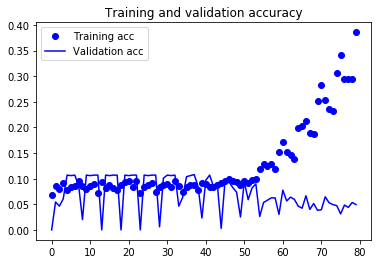

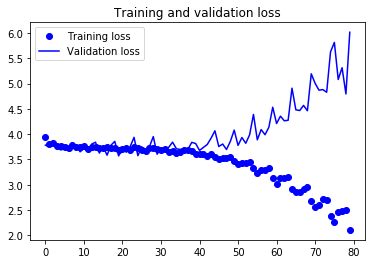

Found 1310 images belonging to 120 classes.
Generated 1320 predictions
test acc: 0.03636363696194056


In [3]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                       input_shape=(107, 107, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(120, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=80,
      validation_data=validation_generator,
      validation_steps=50)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(107, 107),
        batch_size=10,
        class_mode='categorical',
        shuffle=False)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=132)
y_hat_test2 = model.predict_generator(test_generator, steps=132)
print('Generated {} predictions'.format(len(y_hat_test2)))
print('test acc:', test_acc)

We can see from the above charts that there is a distinct point of increased learning around the 50th epoch.  This was true for all of my trials involving more than 50 epochs.  Below I create the dataframe by converting the prediction array into an actual prediction by identifying the highest prediction value.  I combine that with the "real" values, which are the label of the folder that each chart came from. I then calculate the error between my prediction and the real result of the trade and then add in the entire confidence table.  Lastly I print out the standard deviation of real returns along with the standard deviation of the errors.

In [35]:
predicted_class_indices=np.argmax(y_hat_test2,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
preds = [labels[k] for k in predicted_class_indices]
y_true = test_generator.classes
real= [labels[k] for k in y_true]
labs=list(labels.values())
conf_table=pd.DataFrame(y_hat_test2,columns=labs)
conf_table=round(conf_table,3)
real=pd.DataFrame(real,columns=['real'])
preds=pd.DataFrame(preds,columns=['pred'])
preds=preds.merge(real,left_index=True,right_index=True)
preds.pred=preds.pred.astype(float)
preds.real=preds.real.astype(float)
preds['error']=preds.real-preds.pred
max_conf=[]
for i in range(len(conf_table)):
    max_conf.append(conf_table.iloc[i,:].max())
max_conf=pd.DataFrame(max_conf,columns=['max_conf'])
preds=preds.merge(max_conf,left_index=True,right_index=True)
preds=preds.merge(conf_table,left_index=True,right_index=True)
print('Standard Deviation of Real Returns: ',round(preds.real.std(),1))
print('Standard Deviation of Prediction Error: ',round(preds.error.std(),1))

Standard Deviation of Real Returns:  28.5
Standard Deviation of Prediction Error:  33.6


## Initial Results
The initial results are not good as the model is counterproductive and increases the standard deviation.  Lets dig a little bit and see if there is value hidden in the model.  Given that each prediction comes with a confidence level, we can make a scatter plot of the confidence level vs the realized error.  The red line is a plot of the standard deviation of error for all trades with a confidence level greater than a given value on the x-axis.  The black line is the standard deviation of realized returns and is the measure we are trying to beat.  Where the red line is lower than the black line is where the model has outperformed.

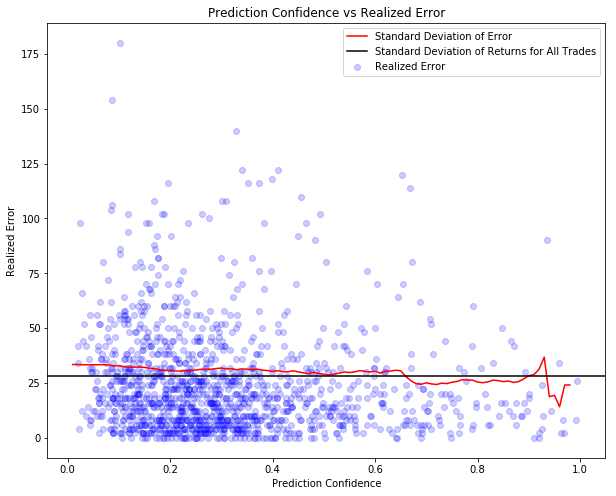

In [47]:
high=int(preds.max_conf.max()*100)
high_stds=[]
I=[]
for i in range(1,high):
    I.append(i/100)
    high_conf=preds[preds.max_conf>i/100]
    high_stds.append(high_conf.error.std())
plt.figure(figsize=(10,8))
plt.plot(I,high_stds,color='red',label='Standard Deviation of Error')
plt.axhline(preds.real.std(),color='black',label='Standard Deviation of Returns for All Trades')
plt.scatter(preds.max_conf,preds.error.abs(),color='blue',alpha=.2,label='Realized Error')
plt.xlabel('Prediction Confidence')
plt.ylabel('Realized Error')
plt.title('Prediction Confidence vs Realized Error')
plt.legend()

We can see that as the confidence gets above about .7 that the red line dips below the black line, meaning that our model is outperforming the baseline.  Below I isolate the trades with confidence levels above .7 for further analysis.

Percent of All Trades with High Confidence:  6.4 %
Standard Deviation of Realized Error on High Confidence Trades:  24.6


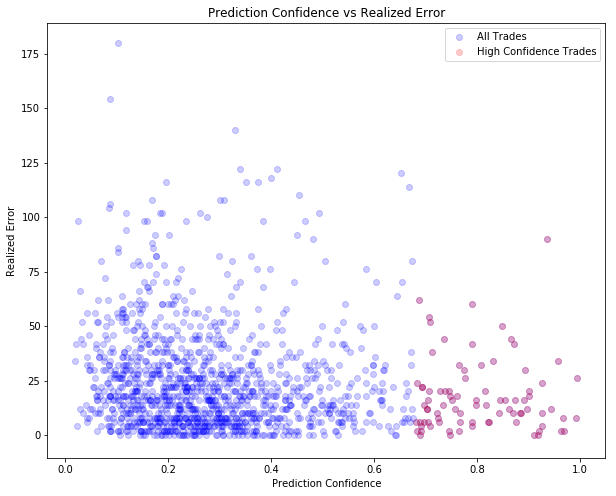

In [54]:
high_conf=preds[preds.max_conf>.7]
print('Percent of All Trades with High Confidence: ',round(100*len(high_conf)/len(preds),1),'%')
print('Standard Deviation of Realized Error on High Confidence Trades: ',round(high_conf.error.std(),1))
plt.figure(figsize=(10,8))
plt.scatter(preds.max_conf,preds.error.abs(),color='blue',alpha=.2, label='All Trades')
plt.scatter(high_conf.max_conf,high_conf.error.abs(),color='red',alpha=.2, label='High Confidence Trades')
plt.xlabel('Prediction Confidence')
plt.ylabel('Realized Error')
plt.title('Prediction Confidence vs Realized Error')
plt.legend()

The high confidence trades have a lower standard deviation than our benchmark; 24.6 vs 28.5.  The model is clearly adding value, however the trade off is that it is only confident on a small number of trades, about 6%.  This may seem demoralizing but if this analysis is run all 5 trading days in a week on all 30 stocks in the Dow Jones, it suggests that out of the 150 possible trades, this model will give us about 9 trades per week; which is plenty for a trader to go on.

In order to see if these results are statistically significant, we can employ Bartlett's test for homogeneity.  However, Bartlett's test requires that the samples be normal distributed.  To test that, I will first employ Shapiro's test.

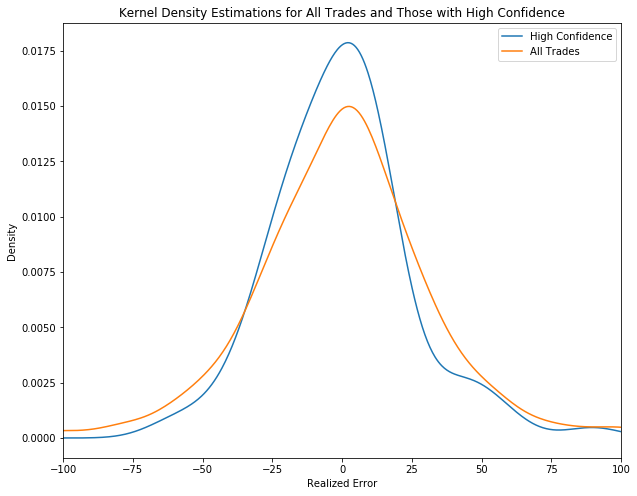

High Confidence Shapiro Coefficient:  0.963
High Confidence Shapiro p-value:  0.016
All Trades Shapiro Coefficient:  0.971
All Trades Shapiro p-value:  0.0
Bartlett Coefficient:  12.088
Bartlett p-value:  0.001


In [57]:
plt.figure(figsize=(10, 8))
high_conf.error.plot.kde(label='High Confidence')
preds.error.plot.kde(label='All Trades')
plt.legend()
plt.xlabel('Realized Error')
plt.title('Kernel Density Estimations for All Trades and Those with High Confidence')
plt.xlim(-100,100)
plt.show()
high_conf_norm,high_conf_p=stats.shapiro(high_conf.error)
all_norm,all_p=stats.shapiro(preds.error)
bartlett_results=stats.bartlett(high_conf.error,preds.error)
print('High Confidence Shapiro Coefficient: ',round(high_conf_norm,3))
print('High Confidence Shapiro p-value: ',round(high_conf_p,3))
print('All Trades Shapiro Coefficient: ',round(all_norm,3))
print('All Trades Shapiro p-value: ',round(all_p,3))
print('Bartlett Coefficient: ',round(bartlett_results[0],3))
print('Bartlett p-value: ',round(bartlett_results[1],3))

First off we can see that Shapiro's p-value is less than .05 for both the high confidence trades and for all trades, meaning that both samples are normally distributed and thus we can use the Bartlett test.  The Bartlett test's p-value is also less than .05 and thus statistically significant. This means that we can reject the null hypothesis and conclude that the model's high confidence stock picks are better at forcasting price movement than the standard deviation of all returns.

## Conclusions:
- The model is of no use for predicting all possible trades but is useful when used on the highest confidence stock chart images.
- A more robust version of a model like this would be extremely useful to options traders but much more inquiry is needed.

## Further Inqury
Before this concept could responsibly be deployed in live trading there would need to be significant improvements to the model including but not limited to:
- Using many more stock charts to train the model, including from companies that have been removed from the Dow Jones or have went bankrupt in order to avoid survivorship bias.
- Use more detailed images and optimize the amount of days included in each chart.
- Include more data in each chart such as volume and other technical indicators.

## For the next section, please see the notebook titled "CNN_Binary_Classification"